<a href="https://colab.research.google.com/github/yashwardhan-gautam/Grid2.0/blob/master/VoiceFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Basic necessary definitions

#### Hyper Parameters

In [2]:
class HyperParams:
  n_fft= 1200
  num_freq= 601 # n_fft//2 + 1
  sample_rate= 16000
  hop_length= 160
  win_length= 400
  min_level_db= -100.0
  ref_level_db= 20.0
  preemphasis= 0.97
  power= 0.30
  embedder_window= 80
  data_audio_len= 3.0
  embedder_num_mels= 40
  embedder_lstm_hidden = 768
  embedder_emb_dim = 256
  embedder_lstm_layers = 3
  embedder_window = 80
  embedder_stride = 40
  model_lstm_dim = 400
  model_fc1_dim = 600
  model_fc2_dim = 601 # num_freq

#### Audio related helper functions

In [3]:
import librosa
import numpy as np  

In [4]:
class Audio:
  def __init__(self,hyper_params):
    self.hyper_params = hyper_params
    self.mel_basis_matrix = librosa.filters.mel(sr=hyper_params.sample_rate,
                                             n_fft=hyper_params.n_fft,
                                             n_mels=hyper_params.embedder_num_mels);

  def get_mel_spec(self,wave):
    spec = librosa.core.stft(y=wave, n_fft=self.hyper_params.n_fft,
                              hop_length=self.hyper_params.hop_length,
                              win_length=self.hyper_params.win_length,
                              window='hann')
    power_spec = np.abs(spec) ** 2
    mel_spec = np.log10(np.dot(self.mel_basis_matrix,power_spec)+1e-6)
    return mel_spec  
  def wave2spec(self,wave): 
    spec = librosa.core.stft(y=wave, n_fft=self.hyper_params.n_fft,
                            hop_length=self.hyper_params.hop_length,
                            win_length=self.hyper_params.win_length)
    phase = np.angle(spec)
    spec_db = self.amp2db(np.abs(spec))
    spec_db_norm = self.normalize(spec_db)
    spec_db_norm = spec_db_norm.T   # Taking transpose here
    phase = phase.T # Taking transpose here
    return spec_db_norm, phase
  def spec2wave(self,spec_db_norm,phase):
    spec_db_norm, phase = spec_db_norm.T, phase.T
    spec_db = self.denormalize(spec_db_norm)
    spec_amp = self.db2amp(spec_db)
    spec = spec_amp * np.exp(1j*phase)
    wave = librosa.core.istft(spec,
                             hop_length=self.hyper_params.hop_length,
                             win_length=self.hyper_params.win_length)
    return wave
  def amp2db(self,mat):
    return 20.0 * np.log10(np.maximum(1e-5,mat)) - self.hyper_params.ref_level_db
  def db2amp(self,mat):
    return np.power(10.0, (mat+self.hyper_params.ref_level_db)*0.05)
  def normalize(self,mat):
    return np.clip((mat-self.hyper_params.min_level_db)/-self.hyper_params.min_level_db, 0.0 , 1.0)
  def denormalize(self, mat):
    return np.clip(mat,0.0,1.0)*(-self.hyper_params.min_level_db)+self.hyper_params.min_level_db

In [5]:
hyper_params = HyperParams()
audio = Audio(hyper_params)

#### Define paths and create folders

In [6]:
import os

### Use pre trained model to obtain Embedding

In [7]:
import torch
import torch.nn as nn

class LinearNorm(nn.Module):
    def __init__(self, hp):
        super(LinearNorm, self).__init__()
        self.linear_layer = nn.Linear(hp.embedder_lstm_hidden, hp.embedder_emb_dim)

    def forward(self, x):
        return self.linear_layer(x)


class SpeechEmbedder(nn.Module):
    def __init__(self, hp):
        super(SpeechEmbedder, self).__init__()
        self.lstm = nn.LSTM(hp.embedder_num_mels,
                            hp.embedder_lstm_hidden,
                            num_layers=hp.embedder_lstm_layers,
                            batch_first=True)
        self.proj = LinearNorm(hp)
        self.hp = hp

    def forward(self, mel):
        # (num_mels, T)
        mels = mel.unfold(1, self.hp.embedder_window, self.hp.embedder_stride) # (num_mels, T', window)
        mels = mels.permute(1, 2, 0) # (T', window, num_mels)
        x, _ = self.lstm(mels) # (T', window, lstm_hidden)
        x = x[:, -1, :] # (T', lstm_hidden), use last frame only
        x = self.proj(x) # (T', emb_dim)
        x = x / torch.norm(x, p=2, dim=1, keepdim=True) # (T', emb_dim)
        x = x.sum(0) / x.size(0) # (emb_dim), average pooling over time frames
        return x

In [9]:
# Embedder downloaded from https://drive.google.com/file/d/1YFmhmUok-W76JkrfA0fzQt3c-ZsfiwfL/view (https://github.com/mindslab-ai/voicefilter)
!cp "drive/MyDrive/LibriSpeech Dataset/embedder.pt" .
embedder_path = "embedder.pt"
embedder_pt = torch.load(embedder_path,map_location=torch.device('cpu'))
embedder = SpeechEmbedder(hyper_params)
embedder.load_state_dict(embedder_pt)
embedder.eval()

SpeechEmbedder(
  (lstm): LSTM(40, 768, num_layers=3, batch_first=True)
  (proj): LinearNorm(
    (linear_layer): Linear(in_features=768, out_features=256, bias=True)
  )
)

### Prepare dataset

In [10]:
import random
import pandas as pd

In [11]:
# returns dvec for the input wave using pre trained embedder model
def get_dvector(wave):
  mel_spec = audio.get_mel_spec(wave)
  dvec = embedder(torch.from_numpy(mel_spec).float())
  dvec = dvec.detach().numpy()
  return dvec

### Create Model

In [12]:
#input dims for model [ T_dim, num_freq ]
T_dim = 301 
num_freq =  hyper_params.num_freq
emb_dim = hyper_params.embedder_emb_dim
lstm_dim =  hyper_params.model_lstm_dim
fc1_dim = hyper_params.model_fc1_dim
fc2_dim = hyper_params.model_fc2_dim #num_freq
batch_size = 8

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Multiply, ZeroPadding2D, concatenate, Conv2D, Input, Dense, Reshape, BatchNormalization, Activation, LSTM, Bidirectional, Lambda

In [14]:
def get_model():
  dvec_inp = Input(shape=[emb_dim],name="dvec")
  input_spec = Input(shape=[T_dim,num_freq],name="input_spec")
  x = Reshape((T_dim,num_freq,1))(input_spec)
 
  # cnn
 
  #cnn1
  x = ZeroPadding2D(((0,0), (3,3)))(x)
  x = Conv2D(filters=64, kernel_size=[1,7], dilation_rate=[1, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn2
  x = ZeroPadding2D(((3,3), (0,0)))(x)
  x = Conv2D(filters=64, kernel_size=[7,1], dilation_rate=[1, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn3
  x = ZeroPadding2D(((2,2), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[1, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn4
  x = ZeroPadding2D(((4,4), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[2, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn5
  x = ZeroPadding2D(((8,8), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[4, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn6
  x = ZeroPadding2D(((16,16), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[8, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn7
  x = ZeroPadding2D(((32,32), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[16, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn8
  x = Conv2D(filters=8, kernel_size=[1,1], dilation_rate=[1, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
   
  x = Reshape((x.shape[1],x.shape[2]*x.shape[3]))(x) #else use -1 as last arg
  #x = tf.reshape(x, [x.shape[0],x.shape[1],-1])
 
  dvec = Lambda(lambda a : tf.expand_dims(a,1))(dvec_inp)
  dvec = Lambda(lambda a : tf.repeat(a,repeats =x.shape[1],axis =1))(dvec)
  #dvec= tf.expand_dims(dvec_inp,1)
  #dvec= tf.repeat(dvec,repeats =x.shape[1],axis =1)
  
  x = concatenate([x,dvec],-1)
  #x= tf.concat([x,dvec],-1)
  
  #lstm
  x = Bidirectional(LSTM(lstm_dim,return_sequences=True))(x)
  
  #fc1
  x = Dense(fc1_dim,activation ="relu")(x)
  #fc2
  mask = Dense(fc2_dim,activation ="sigmoid",name="mask")(x) #soft mask
  
  #element-wise
  output = Multiply()([input_spec,mask])

  model = Model(inputs=[input_spec,dvec_inp], outputs=output)
 
  return model

In [15]:
model = get_model()
#model_val = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_spec (InputLayer)         [(None, 301, 601)]   0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 301, 601, 1)  0           input_spec[0][0]                 
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 301, 607, 1)  0           reshape[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 301, 601, 64) 512         zero_padding2d[0][0]             
______________________________________________________________________________________________

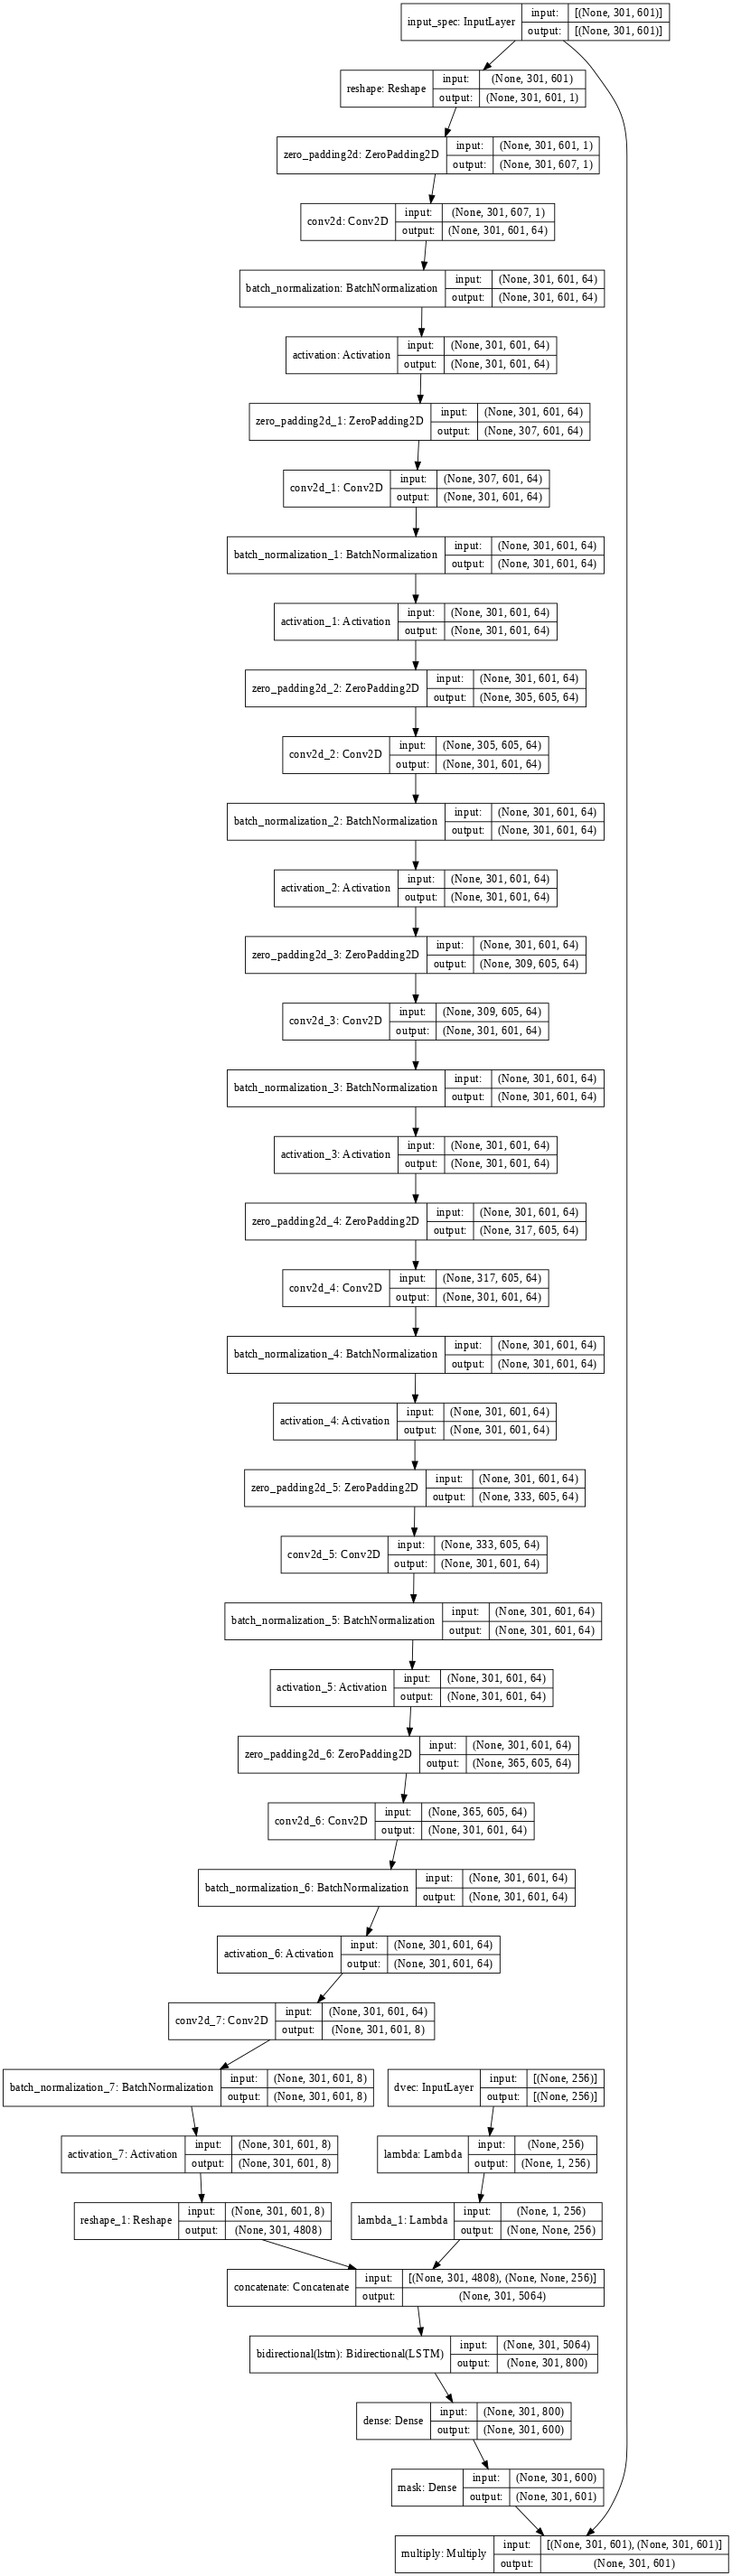

In [16]:
model.compile(optimizer='adam', loss='mse')
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

### Load Data and Train


In [17]:
!pip install mir_eval

     |████████████████████████████████| 92kB 3.5MB/s 
  Created wheel for mir-eval: filename=mir_eval-0.6-cp37-none-any.whl size=96515 sha256=f3baf1ef6b63f430639a5d553843fd817692082720565392040f2fa975fe1c9e
  Stored in directory: /root/.cache/pip/wheels/49/ce/30/730fa72addf275e49d90683b01b3613048b4be3bf7ff8eb6ec
Successfully built mir-eval


In [18]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.utils import Sequence

In [19]:
from tensorflow.keras.utils import Sequence

In [20]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm

### Visualize model training

In [21]:
!pip install mir_eval

In [22]:
import pandas as pd
import numpy as np
from mir_eval.separation import bss_eval_sources
from tqdm import tqdm

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

### Test audio samples

In [24]:
## preprocess audio in the same way as training audio input
def preprocess_audio(audio_path):
  wave,_ = librosa.load(audio_path,sr=hyper_params.sample_rate) 
  wave,_ = librosa.effects.trim(wave, top_db=20)  #trim silent portions
  length_wave = int(hyper_params.sample_rate * hyper_params.data_audio_len) 
  if(wave.shape[0]<length_wave) :
    return
  wave = wave[:length_wave] #clip wave to a fixed wavelength
  norm = np.max(np.abs(wave)) * 1.1 #normalize
  wave = wave/norm
  return wave

In [25]:
from IPython.display import Audio as ipythonAudio
import pandas as pd
import numpy as np
import librosa
import random

In [130]:
## pass input spec and dvec thru model and re construct wave after combining with input phase
def get_filtered_wave(input_spec, phase, dvec):
  dvec = np.expand_dims(dvec,axis=0)
  input_spec = np.expand_dims(input_spec,axis=0)
  clean_spec = model.predict(x={ 'input_spec' : input_spec, 'dvec' : dvec}, verbose=1)
  wave = audio.spec2wave(clean_spec[0],phase)
  return np.asarray(wave)


hyper_params = HyperParams()
audio = Audio(hyper_params)

ref_wave, _ = librosa.load("drive/MyDrive/LibriSpeech Dataset/Sample Audios/Case 1/1_ref.flac",sr=hyper_params.sample_rate) #load the audio file
pri_wave, _ = librosa.load("drive/MyDrive/LibriSpeech Dataset/Sample Audios/Case 1/1_pri.flac", sr = hyper_params.sample_rate)
sec_wave,_ = librosa.load("drive/MyDrive/LibriSpeech Dataset/Sample Audios/Case 1/1_sec.flac", sr = hyper_params.sample_rate)

length_wave = int(hyper_params.sample_rate * hyper_params.data_audio_len)
pri_wave, sec_wave = pri_wave[:length_wave], sec_wave[:length_wave] # clip wave to fixed length
# pri_wave = pri_wave[:length_wave] # clip wave to fixed length
mix_wave = pri_wave + sec_wave
# mix_wave = pri_wave
norm = np.max(np.abs(mix_wave)) * 1.1
pri_wave, mix_wave = pri_wave/norm , mix_wave/norm  # normalize wave by 1.1*max(absolute amplitude)
pri_spec, pri_phase = audio.wave2spec(pri_wave)  # convert wave to spec
mix_spec, mix_phase = audio.wave2spec(mix_wave)

dvec = get_dvector(ref_wave)

In [143]:
## pass input spec and dvec thru model and re construct wave after combining with input phase
def get_filtered_wave(input_spec, phase, dvec):
  dvec = np.expand_dims(dvec,axis=0)
  input_spec = np.expand_dims(input_spec,axis=0)
  clean_spec = model.predict(x={ 'input_spec' : input_spec, 'dvec' : dvec}, verbose=1)
  wave = audio.spec2wave(clean_spec[0],phase)
  return np.asarray(wave)


hyper_params = HyperParams()
audio = Audio(hyper_params)

ref_wave, _ = librosa.load("drive/MyDrive/LibriSpeech Dataset/Sample Audios/Case 4/2_ref.flac",sr=hyper_params.sample_rate) #load the audio file
pri_wave, _ = librosa.load("drive/MyDrive/LibriSpeech Dataset/Sample Audios/Case 4/2_pri.flac", sr = hyper_params.sample_rate)
sec_wave1,_ = librosa.load("drive/MyDrive/LibriSpeech Dataset/Sample Audios/Case 4/2_sec1.flac", sr = hyper_params.sample_rate)
sec_wave2,_ = librosa.load("drive/MyDrive/LibriSpeech Dataset/Sample Audios/Case 4/2_sec2.flac", sr = hyper_params.sample_rate)

length_wave = int(hyper_params.sample_rate * hyper_params.data_audio_len)
pri_wave, sec_wave1, sec_wave2 = pri_wave[:length_wave], sec_wave1[:length_wave], sec_wave2[:length_wave] # clip wave to fixed length
# pri_wave = pri_wave[:length_wave] # clip wave to fixed length
mix_wave = pri_wave + sec_wave1 + sec_wave2
# mix_wave = pri_wave
norm = np.max(np.abs(mix_wave)) * 1.1
pri_wave, mix_wave = pri_wave/norm , mix_wave/norm  # normalize wave by 1.1*max(absolute amplitude)
pri_spec, pri_phase = audio.wave2spec(pri_wave)  # convert wave to spec
mix_spec, mix_phase = audio.wave2spec(mix_wave)

dvec = get_dvector(ref_wave)

In [144]:
# ref wave
ipythonAudio(ref_wave, rate = hyper_params.sample_rate)

In [145]:
# pri wave
ipythonAudio(pri_wave, rate = hyper_params.sample_rate)

In [146]:
# sec wave
ipythonAudio(sec_wave, rate = hyper_params.sample_rate)

In [147]:
# mix wave
ipythonAudio(mix_wave, rate = hyper_params.sample_rate)

In [148]:
# filtered wave after 0 epochs
model.load_weights(os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch0000.h5'))
filtered_wave = get_filtered_wave(mix_spec, mix_phase, dvec)
ipythonAudio(filtered_wave, rate = hyper_params.sample_rate)

1/1 [==============================] - 0s 340ms/step


In [149]:
# filtered wave after 40 epochs
model.load_weights(os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch0040.h5'))
filtered_wave = get_filtered_wave(mix_spec, mix_phase, dvec)
ipythonAudio(filtered_wave, rate = hyper_params.sample_rate)

1/1 [==============================] - 0s 298ms/step


In [33]:
## pass input spec and dvec thru model and re construct wave after combining with input phase
def get_filtered_wave(input_spec, phase, dvec):
  dvec = np.expand_dims(dvec,axis=0)
  input_spec = np.expand_dims(input_spec,axis=0)
  clean_spec = model.predict(x={ 'input_spec' : input_spec, 'dvec' : dvec}, verbose=1)
  wave = audio.spec2wave(clean_spec[0],phase)
  return np.asarray(wave)


hyper_params = HyperParams()
audio = Audio(hyper_params)

ref_wave, _ = librosa.load("drive/MyDrive/LibriSpeech Dataset/sample_audios/5_ref.flac",sr=hyper_params.sample_rate) #load the audio file
pri_wave, _ = librosa.load("drive/MyDrive/LibriSpeech Dataset/sample_audios/6_pri.flac", sr = hyper_params.sample_rate)

length_wave = int(hyper_params.sample_rate * hyper_params.data_audio_len)
pri_wave = pri_wave[:length_wave] # clip wave to fixed length
mix_wave = pri_wave
norm = np.max(np.abs(mix_wave)) * 1.1
pri_wave, mix_wave = pri_wave/norm , mix_wave/norm  # normalize wave by 1.1*max(absolute amplitude)
pri_spec, pri_phase = audio.wave2spec(pri_wave)  # convert wave to spec
mix_spec, mix_phase = audio.wave2spec(mix_wave)

dvec = get_dvector(ref_wave)

In [34]:
# ref wave
ipythonAudio(ref_wave, rate = hyper_params.sample_rate)

In [35]:
# pri wave
ipythonAudio(pri_wave, rate = hyper_params.sample_rate)

In [36]:
# mix wave
ipythonAudio(mix_wave, rate = hyper_params.sample_rate)

In [37]:
# filtered wave after 0 epochs
model.load_weights(os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch0000.h5'))
filtered_wave = get_filtered_wave(pri_spec, pri_phase, dvec)
ipythonAudio(filtered_wave, rate = hyper_params.sample_rate)

1/1 [==============================] - 0s 281ms/step


In [38]:
# filtered wave after 40 epochs
model.load_weights(os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch0040.h5'))
filtered_wave = get_filtered_wave(pri_spec, pri_phase, dvec)
ipythonAudio(filtered_wave, rate = hyper_params.sample_rate)

1/1 [==============================] - 0s 258ms/step
